In [1]:
import pytz
import datetime as dt
import lightgbm as lgb

from helper.future_price_retriever import FuturePriceRetriever
from future_arb.mean_reversion import SpreadTradingStrategy
from matplotlib import pyplot as plt

start_date = "20140601"
end_date = dt.datetime.now(pytz.timezone("Asia/Shanghai")).strftime("%Y%m%d")

# Example usage
symbols = ["RB", "HC"]
future_price_retriever = FuturePriceRetriever(start_date=start_date)

# Retrieve spread data
rb_hc_day_spread_df = future_price_retriever.get_spread_data(symbols, frequency="1d")

C:\Users\yanzh\AppData\Local\Programs\Python\Python313\Lib\site-packages\rqdatac\client.py:257: UserWarning: Your account will be expired after  6 days. Please call us at 0755-22676337 to upgrade or purchase or renew your contract.
  warnings.warn("Your account will be expired after  {} days. "


 that has fixed positions

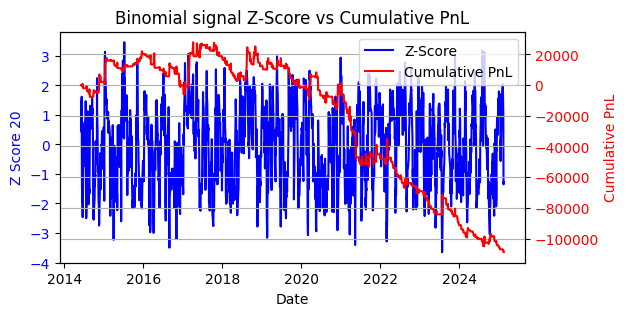

In [2]:
lockback_period = 20
entry_threshold = 2
exit_threshold = 1

# Instantiate strategy
strategy = SpreadTradingStrategy()
rb_hc_processed_spread_df = strategy.compute_moving_statistics(rb_hc_day_spread_df, target_col="RB_HC_spread", window=lockback_period)

# Generate signals
rb_hc_processed_signal_df = strategy.evaluate_binomial_signals(
    rb_hc_processed_spread_df, window=lockback_period, entry_threshold=1.5, exit_threshold=0.5
)
# Calculate PnL
pnl_df = strategy.calculate_binomial_pnl(rb_hc_processed_signal_df, hedge_ratio=1)

fig, ax1 = plt.subplots(figsize=(6, 3))
# Plot z-score on primary y-axis
ax1.plot(pnl_df.index, pnl_df[f"z_score_{lockback_period}d"], color="blue", label="Z-Score")
ax1.set_xlabel("Date")
ax1.set_ylabel(f"Z Score {lockback_period}", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
# Create secondary y-axis for Cumulative PnL
ax2 = ax1.twinx()
ax2.plot(pnl_df.index, pnl_df["CUM_PNL"], color="red", label="Cumulative PnL")
ax2.set_ylabel("Cumulative PnL", color="red")
ax2.tick_params(axis="y", labelcolor="red")
plt.title("Binomial signal Z-Score vs Cumulative PnL")
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid(True)

Position Sizing Based on tanh normazlied z score Prediction Strength

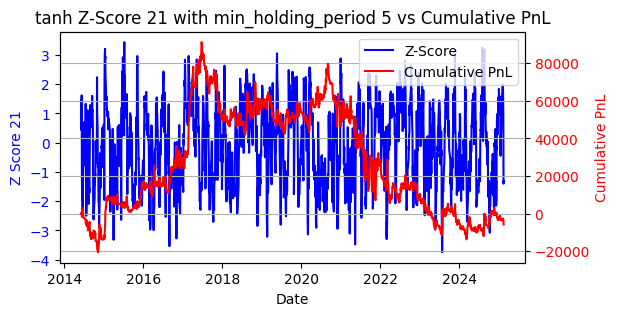

In [3]:
lockback_period = 21
entry_threshold = 0.8
exit_threshold = 0.5
min_holding_period = 5
max_position_size = 100

# Instantiate strategy
strategy = SpreadTradingStrategy()
rb_hc_processed_spread_df = strategy.compute_moving_statistics(rb_hc_day_spread_df, target_col="RB_HC_spread", window=lockback_period)

# Generate signals
rb_hc_processed_signal_df = strategy.evaluate_z_score_signals(rb_hc_processed_spread_df, window=lockback_period, signal_col="Z_SCORE_SIGNAL")
# Calculate PnL
pnl_df = strategy.calculate_z_score_tanh_pnl(
    rb_hc_processed_signal_df,
    hedge_ratio=1,
    entry_threshold=entry_threshold,
    exit_threshold=exit_threshold,
    max_position_size=max_position_size,
    min_holding_period=min_holding_period,
    window=lockback_period,
    signal_col="Z_SCORE_SIGNAL",
)

fig, ax1 = plt.subplots(figsize=(6, 3))
# Plot z-score on primary y-axis
ax1.plot(pnl_df.index, pnl_df[f"z_score_{lockback_period}d"], color="blue", label="Z-Score")
ax1.set_xlabel("Date")
ax1.set_ylabel(f"Z Score {lockback_period}", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
# Create secondary y-axis for Cumulative PnL
ax2 = ax1.twinx()
ax2.plot(pnl_df.index, pnl_df["CUM_PNL"], color="red", label="Cumulative PnL")
ax2.set_ylabel("Cumulative PnL", color="red")
ax2.tick_params(axis="y", labelcolor="red")
plt.title(f"tanh Z-Score {lockback_period} with min_holding_period {min_holding_period} vs Cumulative PnL")
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid(True)

In [4]:
pnl_df

,HC_prices,RB_prices,RB_HC_spread,z_score_21d,Z_SCORE_SIGNAL,PNL,CUM_PNL,TANH_Z_SIGNAL,position_size,holding_days,Z_SCORE_POSITION_RB,Z_SCORE_POSITION_HC
date,,,,,,,,,,,,
2014-06-03,268.00,521.00,253.00,NaN,NaN,0.000000,0.000000,NaN,NaN,1,0.000000,0.000000
2014-06-04,269.50,524.25,254.75,0.707107,-0.707107,0.000000,0.000000,NaN,0.000000,1,0.000000,-0.000000
2014-06-05,271.50,526.00,254.50,0.440225,-0.440225,0.000000,0.000000,0.888386,0.000000,2,0.000000,-0.000000
2014-06-06,278.00,538.25,260.25,1.454995,-1.454995,-43.508683,-43.508683,0.706645,88.838556,3,88.838556,-88.838556
2014-06-09,272.00,534.75,262.75,1.353646,-1.353646,179.094087,135.585404,0.994082,0.000000,4,0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-07,3451.75,3357.25,-94.50,1.822332,-1.822332,199.569035,-2631.999243,0.998599,99.859910,2162,99.859910,-99.859910
2025-02-10,3442.75,3343.00,-99.75,1.021473,-1.021473,-524.279291,-3156.278534,0.998635,99.863536,2163,99.863536,-99.863536
2025-02-11,3413.25,3305.50,-107.75,-0.042285,0.042285,-811.685695,-3967.964229,0.966939,96.693947,2164,96.693947,-96.693947


Normalized signal that sizes the positions

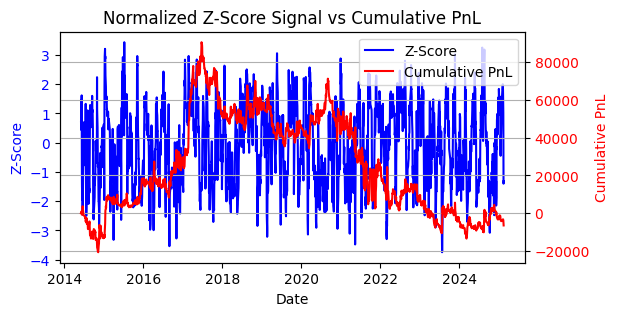

In [5]:
lockback_period = 21
entry_threshold = 1.5
exit_threshold = 0.5

# Instantiate strategy
strategy = SpreadTradingStrategy()
# Process the spread data
rb_hc_20d_spread_df = strategy.compute_moving_statistics(rb_hc_day_spread_df, target_col="RB_HC_spread", window=lockback_period)
# Generate z-score signals
rb_hc_continuous_signal_df = strategy.evaluate_z_score_signals(rb_hc_20d_spread_df, window=lockback_period, signal_col="Z_SCORE_SIGNAL")

# Calculate PnL
z_score_pnl_df = strategy.calculate_clipping_z_score_pnl(
    rb_hc_continuous_signal_df, signal_col="Z_SCORE_SIGNAL", window=lockback_period, hedge_ratio=1, entry_threshold=1, max_position_size=100
)

fig, ax1 = plt.subplots(figsize=(6, 3))
# Plot z-score on primary y-axis
ax1.plot(z_score_pnl_df.index, z_score_pnl_df[f"z_score_{lockback_period}d"], color="blue", label="Z-Score")
ax1.set_xlabel("Date")
ax1.set_ylabel("Z-Score", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
# Create secondary y-axis for Cumulative PnL
ax2 = ax1.twinx()
ax2.plot(z_score_pnl_df.index, z_score_pnl_df["CUM_PNL"], color="red", label="Cumulative PnL")
ax2.set_ylabel("Cumulative PnL", color="red")
ax2.tick_params(axis="y", labelcolor="red")
plt.title("Normalized Z-Score Signal vs Cumulative PnL")
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)
plt.grid(True)

More statistic signals

In [6]:
lockback_periods = [2, 3, 5, 8, 13, 21, 34]
hist_vol_windows = [5, 10, 21, 42, 68, 100, 252]

entry_threshold = 1.5
exit_threshold = 0.5

# Instantiate strategy
strategy = SpreadTradingStrategy()
# Process the spread data
rb_hc_fibo_z_score = strategy.compute_moving_statistics(rb_hc_day_spread_df, target_col="RB_HC_spread", window=lockback_periods)
rb_hc_fibo_z_score
rb_hc_fibonacci_spread_df = strategy.compute_historical_volatility(
    rb_hc_fibo_z_score, price_cols=["RB_prices", "HC_prices"], window=lockback_periods
)
rb_hc_fibonacci_spread_df.columns

Index(['HC_prices', 'RB_prices', 'RB_HC_spread', 'z_score_2d', 'z_score_3d',
       'z_score_5d', 'z_score_8d', 'z_score_13d', 'z_score_21d', 'z_score_34d',
       'HIST_VOL_2_RB_prices', 'HIST_VOL_2_HC_prices', 'HIST_VOL_3_RB_prices',
       'HIST_VOL_3_HC_prices', 'HIST_VOL_5_RB_prices', 'HIST_VOL_5_HC_prices',
       'HIST_VOL_8_RB_prices', 'HIST_VOL_8_HC_prices', 'HIST_VOL_13_RB_prices',
       'HIST_VOL_13_HC_prices', 'HIST_VOL_21_RB_prices',
       'HIST_VOL_21_HC_prices', 'HIST_VOL_34_RB_prices',
       'HIST_VOL_34_HC_prices'],
      dtype='object')

Mutiple signals with different windows to capture temporal infomation

d:\GitHub\FICC_QIS\future_arb\lightgbm_strategy.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_df[signal_col] = self.model.predict(X)


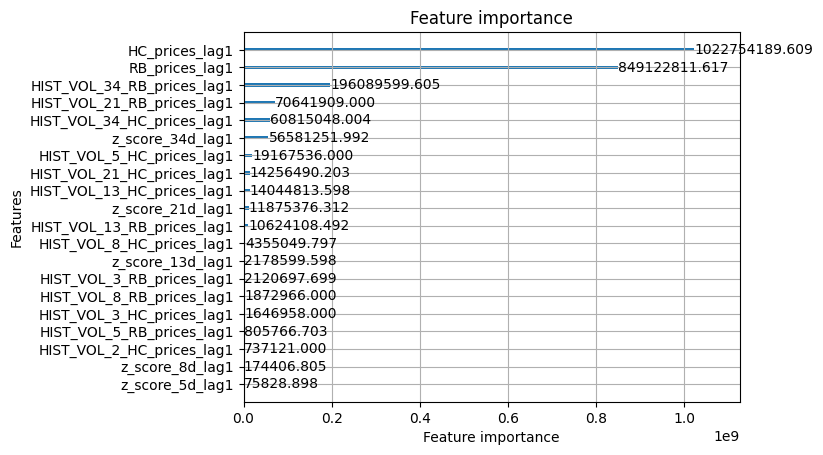

In [7]:
from future_arb.lightgbm_strategy import LightGBMSpreadTradingStrategy


lockback_periods = [1, 2, 3, 5, 8, 13, 21, 34]
hist_vol_windows = [5, 10, 21, 42, 68, 100, 252]
hedge_ratio = 1
# entry_threshold = 2
# exit_threshold = 1

# Process the spread data
rb_hc_fibonacci_spread_df = strategy.compute_moving_statistics(rb_hc_day_spread_df, target_col="RB_HC_spread", window=lockback_periods)
rb_hc_fibonacci_spread_df = strategy.compute_historical_volatility(
    rb_hc_fibonacci_spread_df, price_cols=["RB_prices", "HC_prices"], window=lockback_periods
)

# Drop columns containing 'mean_' and 'sd_' from rb_hc_fibonacci_spread_df
display_cols = [col for col in rb_hc_fibonacci_spread_df.columns if not ("mean_" in col or "sd_" in col)]
rb_hc_fibonacci_spread_df[display_cols]

Y_cols = ["RB_HC_spread"]
X_cols = [col for col in display_cols if col not in Y_cols]
lagged_X_cols = []
for col in X_cols:
    rb_hc_fibonacci_spread_df[f"{col}_lag1"] = rb_hc_fibonacci_spread_df[col].shift(1)
    lagged_X_cols.append(f"{col}_lag1")
lagged_X_cols
"""
['HC_prices',
'RB_prices',
'z_score_1d',
'z_score_2d',
'z_score_3d',
'z_score_5d',
'z_score_8d',
'z_score_13d',
'z_score_21d',
'z_score_34d',
'z_score_55d',
'z_score_89d']
"""

# Prepare train test dataset
lightgbm_strat = LightGBMSpreadTradingStrategy(hedge_ratio)
xY_df = rb_hc_fibonacci_spread_df[lagged_X_cols + Y_cols]
train_df, test_df = lightgbm_strat.split_data(xY_df)

# Training model is at lightgbm_strat.model
lightgbm_strat.train_model(spread_df=train_df, feature_cols=lagged_X_cols, target_col=Y_cols)

# Feature importance
lgb.plot_importance(lightgbm_strat.model, importance_type="gain")

# Testing


# Evaulation
result_col = "LIGHTGBM_SIGNAL"
result_df = lightgbm_strat.predict_signals(xY_df, feature_cols=lagged_X_cols, signal_col=result_col)

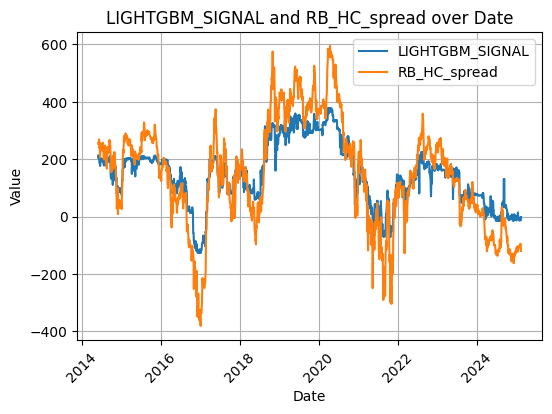

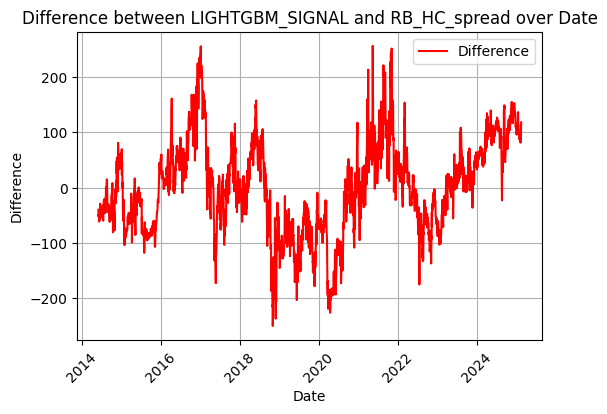

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(result_df.index, result_df["LIGHTGBM_SIGNAL"], label="LIGHTGBM_SIGNAL")
plt.plot(result_df.index, result_df["RB_HC_spread"], label="RB_HC_spread")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("LIGHTGBM_SIGNAL and RB_HC_spread over Date")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 计算两列的差值
diff = result_df["LIGHTGBM_SIGNAL"] - result_df["RB_HC_spread"]

plt.figure(figsize=(6, 4))
plt.plot(result_df.index, diff, label="Difference", color="red")
plt.xlabel("Date")
plt.ylabel("Difference")
plt.title("Difference between LIGHTGBM_SIGNAL and RB_HC_spread over Date")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [9]:
df = result_df.copy()
df.rename(columns={"LIGHTGBM_SIGNAL": "LIGHTGBM_SPREAD"}, inplace=True)

df["long_signal"] = df["LIGHTGBM_SPREAD"] > df["RB_HC_spread"]
df["short_signal"] = df["LIGHTGBM_SPREAD"] < df["RB_HC_spread"]

import numpy as np

df["signal_strength"] = df["LIGHTGBM_SPREAD"] - df["RB_HC_spread"]
df["position_size"] = np.tanh(2 * df["signal_strength"]) * max_position_size  # Scaled position


Next day signal > Today spread:

In [10]:
from future_arb.lightgbm_strategy import LightGBMSpreadTradingStrategy


lockback_periods = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89]
hedge_ratio = 1
# entry_threshold = 2
# exit_threshold = 1

# Process the spread data
rb_hc_fibonacci_spread_df = strategy.compute_moving_statistics(rb_hc_day_spread_df, window=lockback_periods)

# Drop columns containing 'mean_' and 'sd_' from rb_hc_fibonacci_spread_df
display_cols = [col for col in rb_hc_fibonacci_spread_df.columns if not ("mean_" in col or "sd_" in col)]
rb_hc_fibonacci_spread_df[display_cols]

rb_hc_fibonacci_spread_df["SPREAD_CHANGE"] = rb_hc_fibonacci_spread_df["RB_HC_spread"].diff()  # Calculate spread change
Y_cols = ["SPREAD_CHANGE"]
X_cols = [col for col in display_cols if col not in Y_cols]
lagged_X_cols = []
for col in X_cols:
    rb_hc_fibonacci_spread_df[f"{col}_lag1"] = rb_hc_fibonacci_spread_df[col].shift(1)
    lagged_X_cols.append(f"{col}_lag1")
lagged_X_cols
"""
['HC_prices',
'RB_prices',
'z_score_1d',
'z_score_2d',
'z_score_3d',
'z_score_5d',
'z_score_8d',
'z_score_13d',
'z_score_21d',
'z_score_34d',
'z_score_55d',
'z_score_89d']
"""

# Prepare train test dataset
lightgbm_strat = LightGBMSpreadTradingStrategy(hedge_ratio)
xY_df = rb_hc_fibonacci_spread_df[lagged_X_cols + Y_cols]
train_df, test_df = lightgbm_strat.split_data(xY_df)

# Training model is at lightgbm_strat.model
lightgbm_strat.train_model(spread_df=train_df, feature_cols=lagged_X_cols, target_col=Y_cols)

# Feature importance
lgb.plot_importance(lightgbm_strat.model, importance_type="gain")

# Testing


# Evaulation
result_col = "LIGHTGBM_SPREAD_CHANGE_SIGNAL"
result_df = lightgbm_strat.predict_signals(xY_df, feature_cols=lagged_X_cols, signal_col=result_col)

# Convert to positions
cum_pnl = lightgbm_strat.calculate_spread_change_signal_pnl(result_df, hedge_ratio=1, max_position_size=100)

TypeError: SpreadDataProcessor.compute_moving_statistics() missing 1 required positional argument: 'target_col'